Epoch 1/50


c:\Users\jagad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0191
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0012
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 9/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0010
Epoch 10/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0010
Epoch 11/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0010
Epoch 12/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 13/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 14/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 15/50
1422/1422 ━━━━━━━━━━━━━━━━━━

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 0.3168705768018481
MSE: 0.18981044620348891
RMSE: 0.4356724069797041
R-Squared: 0.9582194317548915
MAPE: 7.423965429083148%


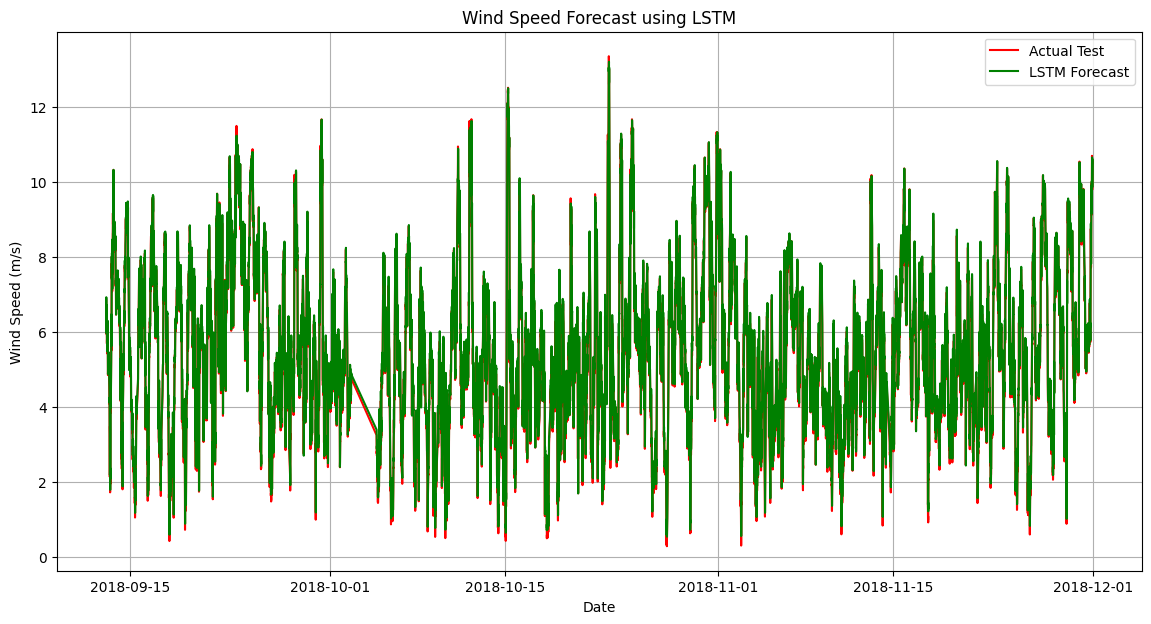

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('../excels/2017-2018-clean.csv', parse_dates=['Date/Time'])

# Drop rows with NaN values
df = df.dropna()

# Prepare the data
df['ds'] = pd.to_datetime(df['Date/Time'])
df.set_index('ds', inplace=True)
data = df['100m_N Avg [m/s]'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Split data into training (first 6 months) and testing (last 6 months) periods
train_size = int(len(data_normalized) * 0.8)
train_data, test_data = data_normalized[:train_size], data_normalized[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Sequence length
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Save the model
model.save('lstm_wind_speed_model.h5')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-Squared: {r_squared}")
print(f"MAPE: {mape}%")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size+seq_length:], y_test_inv, label='Actual Test', color='red')
plt.plot(df.index[train_size+seq_length:], y_pred_inv, label='LSTM Forecast', color='green')
plt.title('Wind Speed Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()


356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 0.30538095492721706
MSE: 0.18235997187936306
RMSE: 0.4270362652976478
R-Squared: 0.9598594102554628
MAPE: 7.07%


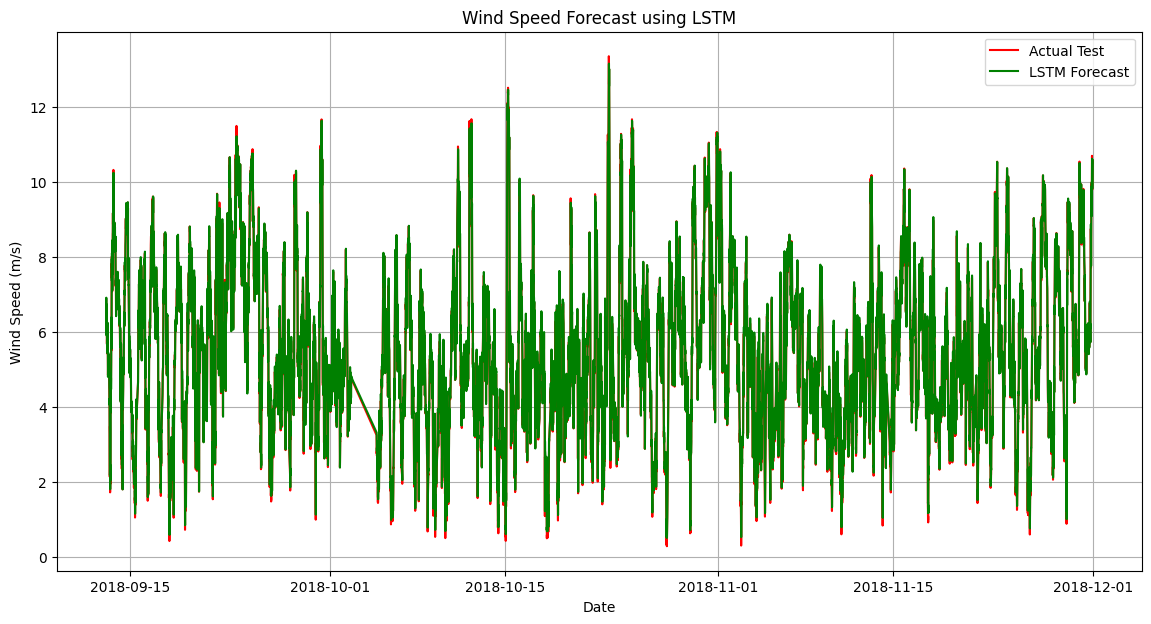

In [4]:
from tensorflow.keras.models import Sequential, load_model
# Load the model from H5 file
loaded_model = load_model('lstm_wind_speed_model.h5')

# Make predictions using the loaded model
y_pred = loaded_model.predict(X_test)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100  # Mean Absolute Percentage Error

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-Squared: {r_squared}")
print(f"MAPE: {mape:.2f}%")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size+seq_length:], y_test_inv, label='Actual Test', color='red')
plt.plot(df.index[train_size+seq_length:], y_pred_inv, label='LSTM Forecast', color='green')
plt.title('Wind Speed Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


c:\Users\jagad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0160
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0012
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 9/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 10/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 11/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 12/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 13/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 14/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 15/50
1422/1422 ━━━━━━━━━━━━━━━━━━

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Data Metrics:
MAE: 0.30538095492721706
MSE: 0.18235997187936306
RMSE: 0.4270362652976478
R-Squared: 0.9598594102554628
MAPE: 7.069557218204219%
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Additional Unseen Data Metrics (2018-2019):
MAE: 0.4014728260897728
MSE: 0.3166960866356068
RMSE: 0.5627575735924011
R-Squared: 0.962139723610616
MAPE: 7.158651986894647%


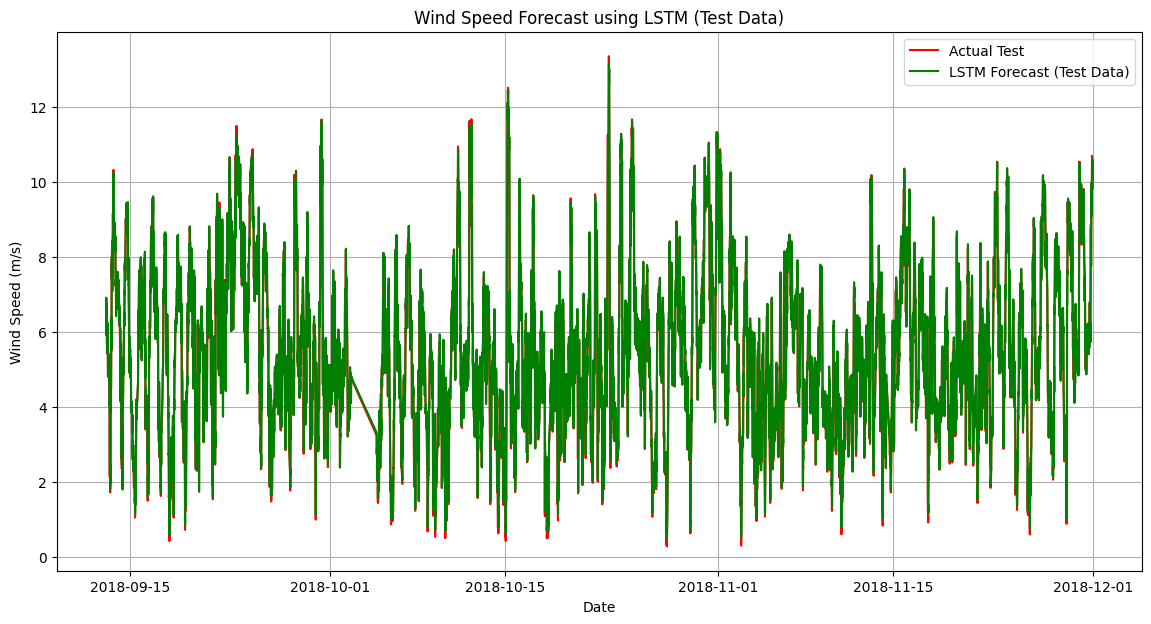

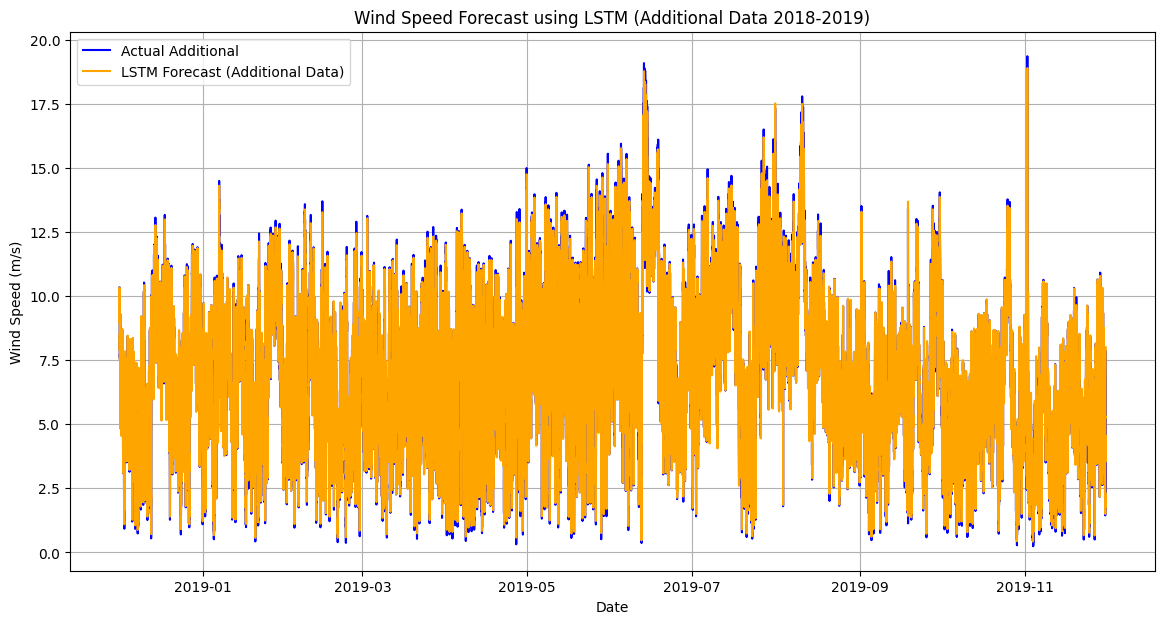

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('../excels/2017-2018-clean.csv', parse_dates=['Date/Time'])

# Drop rows with NaN values
df = df.dropna()

# Prepare the data
df['ds'] = pd.to_datetime(df['Date/Time'])
df.set_index('ds', inplace=True)
data = df['100m_N Avg [m/s]'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Split data into training (first 6 months) and testing (last 6 months) periods
train_size = int(len(data_normalized) * 0.8)
train_data, test_data = data_normalized[:train_size], data_normalized[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Sequence length
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Save the model
model.save('lstm_wind_speed_model.h5')

# Load the saved model (if restarting from here)
# model = load_model('lstm_wind_speed_model.h5')

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics for test data
mae_test = mean_absolute_error(y_test_inv, y_pred_inv)
mse_test = mean_squared_error(y_test_inv, y_pred_inv)
rmse_test = np.sqrt(mse_test)
r_squared_test = r2_score(y_test_inv, y_pred_inv)
mape_test = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("Test Data Metrics:")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R-Squared: {r_squared_test}")
print(f"MAPE: {mape_test}%")

# Load additional unseen data for evaluation (2018-2019)
df_additional = pd.read_csv('../excels/2018-2019-clean.csv', parse_dates=['Date/Time'])

# Drop rows with NaN values
df_additional = df_additional.dropna()

# Prepare the additional data
df_additional['ds'] = pd.to_datetime(df_additional['Date/Time'])
df_additional.set_index('ds', inplace=True)
data_additional = df_additional['100m_N Avg [m/s]'].values.reshape(-1, 1)

# Normalize the additional data using the same scaler
data_normalized_additional = scaler.transform(data_additional)

# Create sequences for LSTM using additional data
X_additional, y_additional = create_sequences(data_normalized_additional, seq_length)

# Reshape data for LSTM input
X_additional = X_additional.reshape(X_additional.shape[0], X_additional.shape[1], 1)

# Make predictions on the additional data
y_pred_additional = model.predict(X_additional)

# Inverse transform the predictions and actual values for additional data
y_pred_inv_additional = scaler.inverse_transform(y_pred_additional)
y_additional_inv = scaler.inverse_transform(y_additional.reshape(-1, 1))

# Calculate accuracy metrics for additional data
mae_additional = mean_absolute_error(y_additional_inv, y_pred_inv_additional)
mse_additional = mean_squared_error(y_additional_inv, y_pred_inv_additional)
rmse_additional = np.sqrt(mse_additional)
r_squared_additional = r2_score(y_additional_inv, y_pred_inv_additional)
mape_additional = np.mean(np.abs((y_additional_inv - y_pred_inv_additional) / y_additional_inv)) * 100

print("\nAdditional Unseen Data Metrics (2018-2019):")
print(f"MAE: {mae_additional}")
print(f"MSE: {mse_additional}")
print(f"RMSE: {rmse_additional}")
print(f"R-Squared: {r_squared_additional}")
print(f"MAPE: {mape_additional}%")

# Plot the results for test data
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size+seq_length:], y_test_inv, label='Actual Test', color='red')
plt.plot(df.index[train_size+seq_length:], y_pred_inv, label='LSTM Forecast (Test Data)', color='green')
plt.title('Wind Speed Forecast using LSTM (Test Data)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for additional data (2018-2019)
plt.figure(figsize=(14, 7))
plt.plot(df_additional.index[seq_length:], y_additional_inv, label='Actual Additional', color='blue')
plt.plot(df_additional.index[seq_length:], y_pred_inv_additional, label='LSTM Forecast (Additional Data)', color='orange')
plt.title('Wind Speed Forecast using LSTM (Additional Data 2018-2019)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


c:\Users\jagad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0104
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0014
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 9/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 10/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 11/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 12/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 13/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 14/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 15/50
1422/1422 ━━━━━━━━━━━━━━━━━━

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Data Metrics (2017-2018):
MAE: 0.30538548044840463
MSE: 0.18332276839630932
RMSE: 0.42816208192261646
R-Squared: 0.9596474820587434
MAPE: 7.0012611023460085%
Epoch 1/50


c:\Users\jagad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0139
Epoch 2/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0012
Epoch 3/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0012
Epoch 4/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 5/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 6/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0011
Epoch 7/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 8/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 9/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 10/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0011
Epoch 11/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0011
Epoch 12/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 13/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 14/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 15/50
1643/1643 ━━━━━━━━━━━━━━━━━━

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Additional Unseen Data Metrics (2018-2019):
MAE: 0.4169685687722805
MSE: 0.3361316068962393
RMSE: 0.5797685804665852
R-Squared: 0.9598162526241062
MAPE: 7.10827067606848%


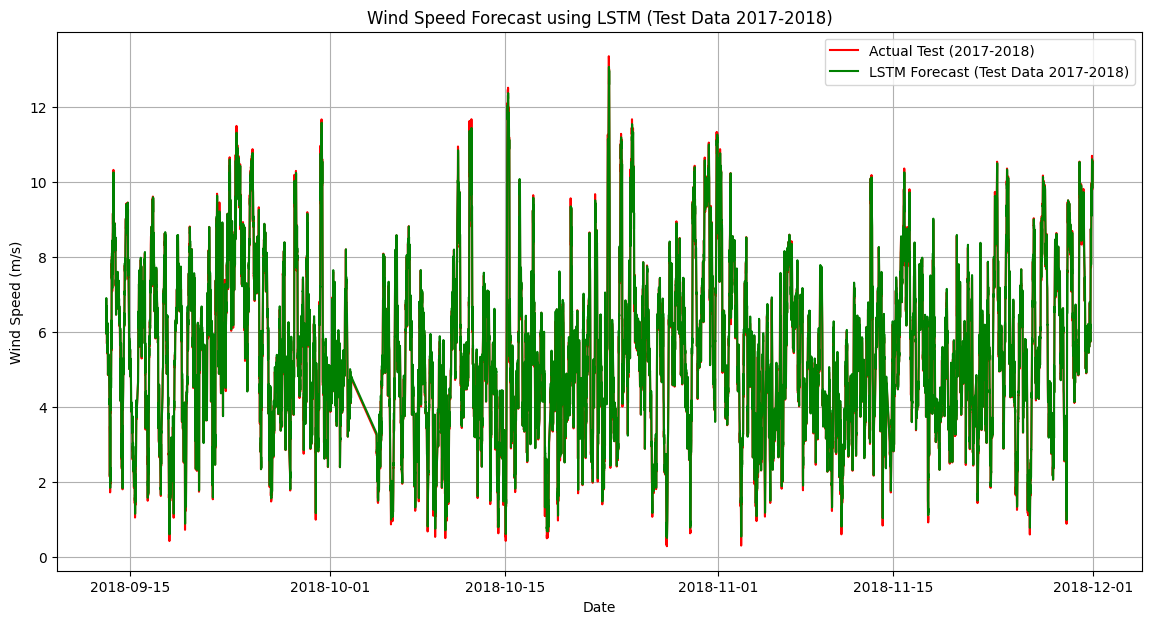

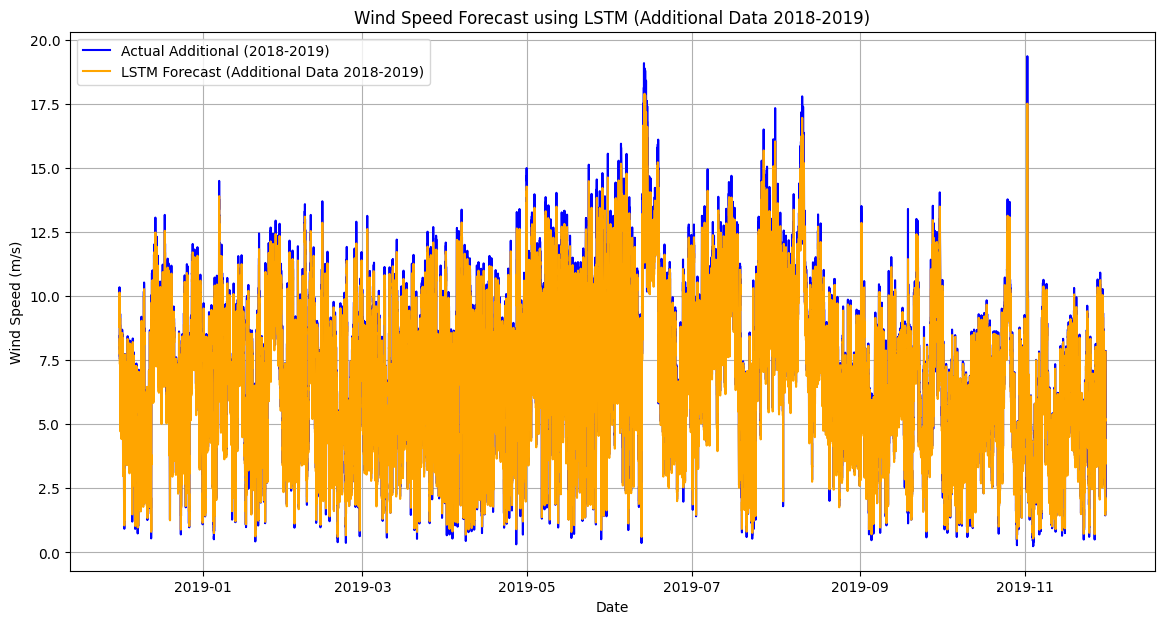

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess the dataset for 2017-2018 data
df = pd.read_csv('../excels/2017-2018-clean.csv', parse_dates=['Date/Time'])

# Drop rows with NaN values
df = df.dropna()

# Prepare the data
df['ds'] = pd.to_datetime(df['Date/Time'])
df.set_index('ds', inplace=True)
data = df['100m_N Avg [m/s]'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Split data into training (first 6 months) and testing (last 6 months) periods
train_size = int(len(data_normalized) * 0.8)
train_data, test_data = data_normalized[:train_size], data_normalized[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Sequence length
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model for 2017-2018 data
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 2017-2018 data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Save the model for 2017-2018 data
model.save('lstm_wind_speed_model_2017_2018.h5')

# Make predictions on the test data (2017-2018)
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values (2017-2018)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics for test data (2017-2018)
mae_test = mean_absolute_error(y_test_inv, y_pred_inv)
mse_test = mean_squared_error(y_test_inv, y_pred_inv)
rmse_test = np.sqrt(mse_test)
r_squared_test = r2_score(y_test_inv, y_pred_inv)
mape_test = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("Test Data Metrics (2017-2018):")
print(f"MAE: {mae_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R-Squared: {r_squared_test}")
print(f"MAPE: {mape_test}%")

# Load additional unseen data for evaluation (2018-2019)
df_additional = pd.read_csv('../excels/2018-2019-clean.csv', parse_dates=['Date/Time'])

# Drop rows with NaN values
df_additional = df_additional.dropna()

# Prepare the additional data
df_additional['ds'] = pd.to_datetime(df_additional['Date/Time'])
df_additional.set_index('ds', inplace=True)
data_additional = df_additional['100m_N Avg [m/s]'].values.reshape(-1, 1)

# Normalize the additional data using the same scaler
data_normalized_additional = scaler.transform(data_additional)

# Create sequences for LSTM using additional data
X_additional, y_additional = create_sequences(data_normalized_additional, seq_length)

# Reshape data for LSTM input
X_additional = X_additional.reshape(X_additional.shape[0], X_additional.shape[1], 1)

# Build the LSTM model for 2018-2019 data
model_additional = Sequential()
model_additional.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model_additional.add(Dense(units=1))
model_additional.compile(optimizer='adam', loss='mean_squared_error')

# Train the model for 2018-2019 data
model_additional.fit(X_additional, y_additional, epochs=50, batch_size=32, verbose=1)

# Save the model for 2018-2019 data
model_additional.save('lstm_wind_speed_model_2018_2019.h5')

# Make predictions on the additional data (2018-2019)
y_pred_additional = model_additional.predict(X_additional)

# Inverse transform the predictions and actual values for additional data (2018-2019)
y_pred_inv_additional = scaler.inverse_transform(y_pred_additional)
y_additional_inv = scaler.inverse_transform(y_additional.reshape(-1, 1))

# Calculate accuracy metrics for additional data (2018-2019)
mae_additional = mean_absolute_error(y_additional_inv, y_pred_inv_additional)
mse_additional = mean_squared_error(y_additional_inv, y_pred_inv_additional)
rmse_additional = np.sqrt(mse_additional)
r_squared_additional = r2_score(y_additional_inv, y_pred_inv_additional)
mape_additional = np.mean(np.abs((y_additional_inv - y_pred_inv_additional) / y_additional_inv)) * 100

print("\nAdditional Unseen Data Metrics (2018-2019):")
print(f"MAE: {mae_additional}")
print(f"MSE: {mse_additional}")
print(f"RMSE: {rmse_additional}")
print(f"R-Squared: {r_squared_additional}")
print(f"MAPE: {mape_additional}%")

# Plot the results for test data (2017-2018)
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size+seq_length:], y_test_inv, label='Actual Test (2017-2018)', color='red')
plt.plot(df.index[train_size+seq_length:], y_pred_inv, label='LSTM Forecast (Test Data 2017-2018)', color='green')
plt.title('Wind Speed Forecast using LSTM (Test Data 2017-2018)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for additional data (2018-2019)
plt.figure(figsize=(14, 7))
plt.plot(df_additional.index[seq_length:], y_additional_inv, label='Actual Additional (2018-2019)', color='blue')
plt.plot(df_additional.index[seq_length:], y_pred_inv_additional, label='LSTM Forecast (Additional Data 2018-2019)', color='orange')
plt.title('Wind Speed Forecast using LSTM (Additional Data 2018-2019)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


c:\Users\jagad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0072
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0012
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0011
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0010
Epoch 9/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0011
Epoch 10/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 11/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 12/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 13/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010
Epoch 14/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011
Epoch 15/50
1422/1422 ━━━━━━━━━━━━━━━━━━

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2017-2018 Data Metrics:
MAE: 0.3066093341216363
MSE: 0.1853262017738393
RMSE: 0.4304952982017798
R-Squared: 0.9592064916568522
MAPE: 6.9508823165121125%
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2018-2019 Data Metrics:
MAE: 0.3494236695888587
MSE: 0.2539507812969805
RMSE: 0.5039352947521939
R-Squared: 0.9605939769432058
MAPE: 7.943350724975906%


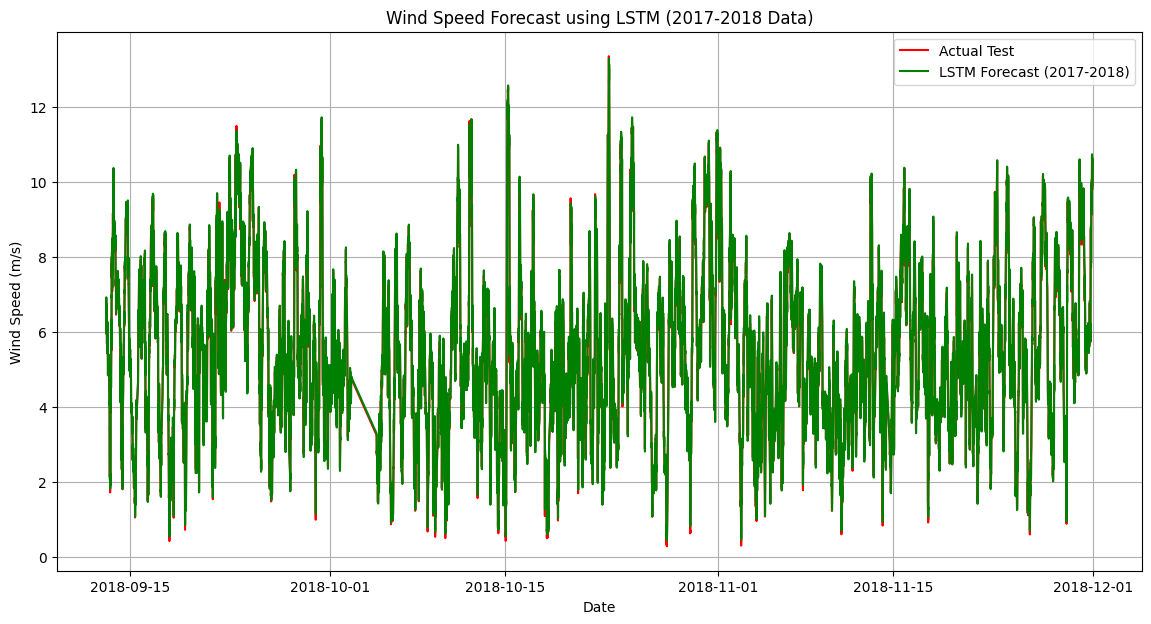

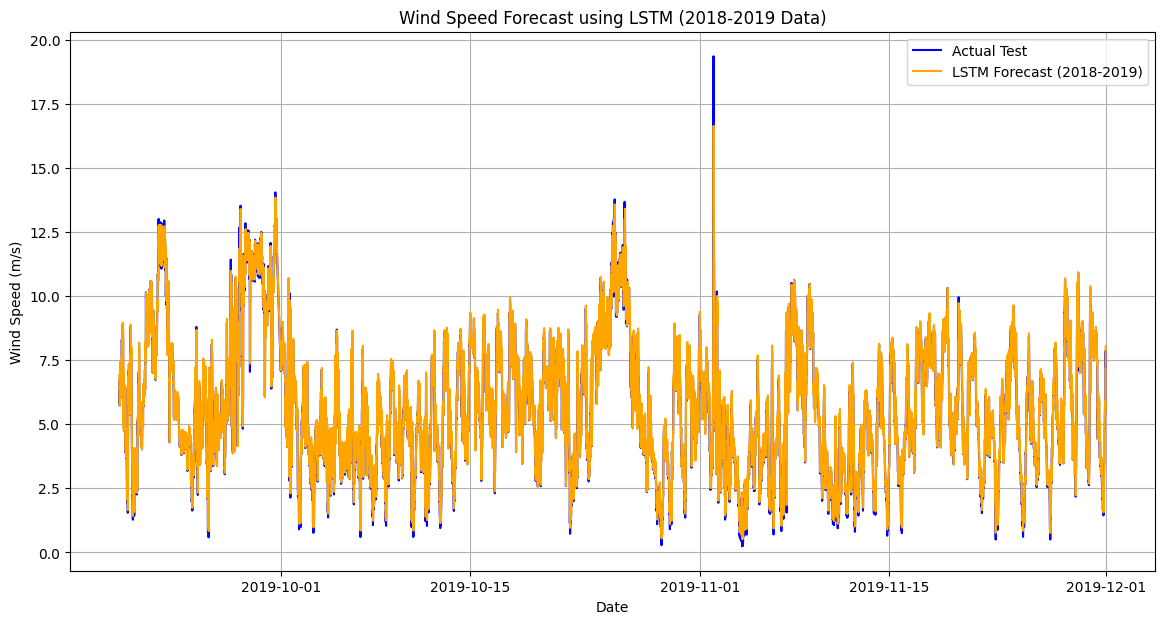

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Load and preprocess the first dataset (2017-2018)
df_1718 = pd.read_csv('../excels/2017-2018-clean.csv', parse_dates=['Date/Time'])
df_1718 = df_1718.dropna()
df_1718['ds'] = pd.to_datetime(df_1718['Date/Time'])
df_1718.set_index('ds', inplace=True)
data_1718 = df_1718['100m_N Avg [m/s]'].values.reshape(-1, 1)
scaler_1718 = MinMaxScaler()
data_normalized_1718 = scaler_1718.fit_transform(data_1718)
train_size_1718 = int(len(data_normalized_1718) * 0.8)
train_data_1718, test_data_1718 = data_normalized_1718[:train_size_1718], data_normalized_1718[train_size_1718:]
X_train_1718, y_train_1718 = create_sequences(train_data_1718, seq_length)
X_test_1718, y_test_1718 = create_sequences(test_data_1718, seq_length)
X_train_1718 = X_train_1718.reshape(X_train_1718.shape[0], X_train_1718.shape[1], 1)
X_test_1718 = X_test_1718.reshape(X_test_1718.shape[0], X_test_1718.shape[1], 1)

# Load and preprocess the second dataset (2018-2019)
df_1819 = pd.read_csv('../excels/2018-2019-clean.csv', parse_dates=['Date/Time'])
df_1819 = df_1819.dropna()
df_1819['ds'] = pd.to_datetime(df_1819['Date/Time'])
df_1819.set_index('ds', inplace=True)
data_1819 = df_1819['100m_N Avg [m/s]'].values.reshape(-1, 1)
scaler_1819 = MinMaxScaler()
data_normalized_1819 = scaler_1819.fit_transform(data_1819)
train_size_1819 = int(len(data_normalized_1819) * 0.8)
train_data_1819, test_data_1819 = data_normalized_1819[:train_size_1819], data_normalized_1819[train_size_1819:]
X_train_1819, y_train_1819 = create_sequences(train_data_1819, seq_length)
X_test_1819, y_test_1819 = create_sequences(test_data_1819, seq_length)
X_train_1819 = X_train_1819.reshape(X_train_1819.shape[0], X_train_1819.shape[1], 1)
X_test_1819 = X_test_1819.reshape(X_test_1819.shape[0], X_test_1819.shape[1], 1)

# Build and train the LSTM model for 2017-2018 dataset
model_1718 = Sequential()
model_1718.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model_1718.add(Dense(units=1))
model_1718.compile(optimizer='adam', loss='mean_squared_error')
model_1718.fit(X_train_1718, y_train_1718, epochs=50, batch_size=32, verbose=1)

# Build and train the LSTM model for 2018-2019 dataset
model_1819 = Sequential()
model_1819.add(LSTM(units=50, activation='relu', input_shape=(seq_length, 1)))
model_1819.add(Dense(units=1))
model_1819.compile(optimizer='adam', loss='mean_squared_error')
model_1819.fit(X_train_1819, y_train_1819, epochs=50, batch_size=32, verbose=1)

# Save both models
model_1718.save('lstm_wind_speed_model_1718.h5')
model_1819.save('lstm_wind_speed_model_1819.h5')

# Evaluate model performance on 2017-2018 dataset
y_pred_1718 = model_1718.predict(X_test_1718)
y_pred_inv_1718 = scaler_1718.inverse_transform(y_pred_1718)
y_test_inv_1718 = scaler_1718.inverse_transform(y_test_1718.reshape(-1, 1))
mae_1718 = mean_absolute_error(y_test_inv_1718, y_pred_inv_1718)
mse_1718 = mean_squared_error(y_test_inv_1718, y_pred_inv_1718)
rmse_1718 = np.sqrt(mse_1718)
r_squared_1718 = r2_score(y_test_inv_1718, y_pred_inv_1718)
mape_1718 = np.mean(np.abs((y_test_inv_1718 - y_pred_inv_1718) / y_test_inv_1718)) * 100

print("2017-2018 Data Metrics:")
print(f"MAE: {mae_1718}")
print(f"MSE: {mse_1718}")
print(f"RMSE: {rmse_1718}")
print(f"R-Squared: {r_squared_1718}")
print(f"MAPE: {mape_1718}%")

# Evaluate model performance on 2018-2019 dataset
y_pred_1819 = model_1819.predict(X_test_1819)
y_pred_inv_1819 = scaler_1819.inverse_transform(y_pred_1819)
y_test_inv_1819 = scaler_1819.inverse_transform(y_test_1819.reshape(-1, 1))
mae_1819 = mean_absolute_error(y_test_inv_1819, y_pred_inv_1819)
mse_1819 = mean_squared_error(y_test_inv_1819, y_pred_inv_1819)
rmse_1819 = np.sqrt(mse_1819)
r_squared_1819 = r2_score(y_test_inv_1819, y_pred_inv_1819)
mape_1819 = np.mean(np.abs((y_test_inv_1819 - y_pred_inv_1819) / y_test_inv_1819)) * 100

print("\n2018-2019 Data Metrics:")
print(f"MAE: {mae_1819}")
print(f"MSE: {mse_1819}")
print(f"RMSE: {rmse_1819}")
print(f"R-Squared: {r_squared_1819}")
print(f"MAPE: {mape_1819}%")

# Plot the results for 2017-2018 dataset
plt.figure(figsize=(14, 7))
plt.plot(df_1718.index[train_size_1718+seq_length:], y_test_inv_1718, label='Actual Test', color='red')
plt.plot(df_1718.index[train_size_1718+seq_length:], y_pred_inv_1718, label='LSTM Forecast (2017-2018)', color='green')
plt.title('Wind Speed Forecast using LSTM (2017-2018 Data)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for 2018-2019 dataset
plt.figure(figsize=(14, 7))
plt.plot(df_1819.index[train_size_1819+seq_length:], y_test_inv_1819, label='Actual Test', color='blue')
plt.plot(df_1819.index[train_size_1819+seq_length:], y_pred_inv_1819, label='LSTM Forecast (2018-2019)', color='orange')
plt.title('Wind Speed Forecast using LSTM (2018-2019 Data)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()
